# rock scissor paper classification
---

In [15]:
import os, glob
import matplotlib.pyplot as plt
import string

from PIL import Image

img_path = os.getenv('HOME') + '/aiffel/data/e1_data/rcp/train/'

target_size = (28,28)

rock_len = 0
scissor_len = 0
paper_len = 0

for num in range(1,42):
    for folder in ['/rock','/scissor','/paper'] :
        images = glob.glob(img_path+str(num)+folder+'/*.jpg')
        #print(folder)
        #print(len(images))
        
        if folder == '/rock':
            rock_len += len(images)
        elif folder == '/scissor':
            scissor_len += len(images)
            #print(len(images))
        else:
            paper_len += len(images)
            
        #if len(images)!=100:
        #    print(img_path+str(num)+folder, len(images))
        
        for img in images:
            old_img = Image.open(img)
            new_img = old_img.resize(target_size,Image.ANTIALIAS)
            new_img.save(img,'JPEG')


#### image들은 36명의 각자의 묵찌빠 사진을 취합하였다
#### 각 사람들의 image는 train dir과 test dir로 나뉘어 1~41 의 이름을 가진 dir에 있으며 
#### 각 사람의 dir안에는 rock paper sccissor의 directory로 나뉘어 image가 들어가있다

<br>

#### 각 directory별로 loop돌면서 모든 image들을 28x28로 resize 시켜주었다.

In [17]:
print('rock_len : ', rock_len)
print('scissor_len : ', scissor_len)
print('paper_len : ', paper_len)

total_img_len = rock_len + scissor_len + paper_len

print('총 이미지 개수 : ', total_img_len)   

rock_len :  2708
scissor_len :  2711
paper_len :  2704
총 이미지 개수 :  8123


#### 가위, 바위, 보 별 이미지 갯수는 위에 나와있는 것과 같으며 총 이미지 갯수는 10523개 이다.

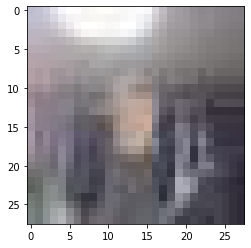

In [3]:
#image check
images = glob.glob(img_path+str(1)+'/rock'+'/*.jpg')

img = Image.open(images[1])
plt.imshow(img)
plt.show()

In [4]:
import numpy as np

img_size=28
color=3
train_image_size = 8424

train_imgs=np.zeros(train_image_size*img_size*img_size*color,dtype=np.int32).reshape(train_image_size,img_size,img_size,color)
train_labels=np.zeros(train_image_size,dtype=np.int32)

print(train_imgs.shape)
print(train_labels.shape)

idx=0



for num in range(1,33):
    for file in glob.glob(img_path+str(num)+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        train_imgs[idx,:,:,:]=img    
        train_labels[idx]=0   # rock : 0
        idx=idx+1

    for file in glob.glob(img_path+str(num)+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        train_imgs[idx,:,:,:]=img    
        train_labels[idx]=1   # scissor : 1
        idx=idx+1
    for file in glob.glob(img_path+str(num)+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        train_imgs[idx,:,:,:]=img   
        train_labels[idx]=2   # paper : 2
        idx=idx+1
    
print("학습데이터(x_train)의 이미지 개수는",idx,"입니다.")

x_train_norm = train_imgs/255.0

print("x_train shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(train_labels.shape))


(8424, 28, 28, 3)
(8424,)
학습데이터(x_train)의 이미지 개수는 8123 입니다.
x_train shape: (8424, 28, 28, 3)
y_train shape: (8424,)


#### test set을 위한(10523, 28, 28, 3) 의 shape를 가진 ndarray를 0으로 initiallize시켜준다
#### training set을 위한 ndarray도 initialize시켜준다
#### 각 rock, scissor, paper 로 분류된 directory 들을 돌며 image들을 test set에 넣고 directory이름을 통해 label도 값을 넣어준다
#### 각 pixel 은 channel당 0-255의 값을 갖기에 0-1의값을 갖도록 normalize 시켜준다.

In [5]:
'''
#from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(x_train_norm, train_labels,test_size=0.00001, shuffle=True)

print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)
'''

(8423, 28, 28, 3)
(1, 28, 28, 3)
(8423,)
(1,)


#### 모든 dataset를 8:2의 비율로 training data와 test data로 split해주었다가 잘못되었음을 느끼고 다시 위에서 train test set 으로 나눔

In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

n_channel_1 = 32
n_channel_2 = 64
n_dense = 128
n_train_epoch=30

def create_model():
    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(n_dense, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))

    model.summary()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=5)

score = cross_val_score(model, x_train_norm, train_labels, cv=kfold, n_jobs=1)

# 모델 훈련
#model.fit(x_tr, y_tr, epochs=n_train_epoch)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

Train on 6740 samples
Epoch 1/5
6740/6740 [==============================] - 1s 89us/sample - loss: 0.8469 - accuracy: 0.5904
Epoch 2/5
6740/6740 [==============================] - 0s 44us/sample - loss: 0.4769 - accuracy: 0.8015
Epoch 3/5
6740/6740 [==============================] - 0s 44us/sample - loss: 0.3087 - accuracy: 0.8797
Epoch 4/5
6740/6740 [==============================] - 0s 44us/sample - loss: 0.2123 - accuracy: 0.9233
Epoch 5/5
1684/1684 [==============================] - 0s 61us/sample - loss: 0.1633 - accuracy: 0.9460


'\n# 모델 시험\ntest_loss, test_accuracy = model2.evaluate(x_val, y_val, verbose=2)\nprint("test_loss: {} ".format(test_loss))\nprint("test_accuracy: {}".format(test_accuracy))\n'

In [14]:
score

array([0.94124627, 0.93056381, 0.93590504, 0.9436202 , 0.94596201])

## cross validation score이 의미가없다.
## train test split도 의미가 없는데...
## 사실 약 40명분당 가위바위보 별 100장씩의 image를  갖고있지만 사실 한명당 3장의 가위바위보에 약간의 노이즈를 추가시킨 99장의 image라고 생각한다
## 더이상 내가아는 검증 방법은없다
## 같은 구조의 모델이 왜 같은 데이터와 같은 파라미터로 학습시켰는데 왜  모델마다 같은 test set에대한 성능차이의 폭이 큰지 모르겠다
## 더이상은 이 프로젝트의 범위를 넘어가는 것 같아 
## 그냥 일단 진행

In [18]:
number_of_data=2100
img_size=28
color=3

test_imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
test_labels=np.zeros(number_of_data,dtype=np.int32)

img_path = os.getenv('HOME') + '/aiffel/data/e1_data/rcp/test/'

idx=0

for num in range(33,42):
    for file in glob.glob(img_path+str(num)+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        test_imgs[idx,:,:,:]=img    
        test_labels[idx]=0   # rock : 0
        idx=idx+1

    for file in glob.glob(img_path+str(num)+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        test_imgs[idx,:,:,:]=img    
        test_labels[idx]=1   # scissor : 1
        idx=idx+1
    for file in glob.glob(img_path+str(num)+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        test_imgs[idx,:,:,:]=img   
        test_labels[idx]=2   # paper : 2
        idx=idx+1
    
print("학습데이터의 이미지 개수는",idx,"입니다.")

x_test_norm = test_imgs/255.0




학습데이터의 이미지 개수는 2100 입니다.


In [8]:
test_loss, test_accuracy = model.evaluate(x_test_norm, test_labels, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))


2100/2100 - 0s - loss: 3.0854 - accuracy: 0.6995
test_loss: 3.0853689590476763 
test_accuracy: 0.6995238065719604
